### setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sys import path as syspath
syspath.append("functions/")

%load_ext autoreload
%autoreload 1
%aimport data_functions, model_functions

import os
from collections import OrderedDict
# from sklearn.linear_model import LogisticRegression, LinearRegression
import pickle
from data_functions import *
from model_functions import *

from copy import deepcopy

In [2]:
def showdf(a_):
    from IPython.display import display
    display(a_.applymap("{0:0.1f}".format))

In [3]:
with open("models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    model = pickle.load(f)

In [4]:
saveFolder = "models/fitted_on_Pr.Pl.36N/extended_parameters/"

In [5]:
DataDict = {
    "Pr": pd.read_csv("Pr_Pl_sequences/Pr_constitutive.csv", usecols=[0,1]),
#     "Pl": pd.read_csv("Pr_Pl_sequences/Pl_constitutive.csv", usecols=[0,1]),
#     "36N": pd.read_csv("36N_seqences/36N_constitutive.csv", usecols=[0,1])
}

RBSPos = {lib:getRBSpositions(DataDict[lib]) for lib in DataDict}

numData = createNumData(DataDict,tts=["all"])



### Unproductive transcript due to proximity to RBS

In [4]:

numAncestor = numData['all']["Pr"]["seqs"][0]

wtPr_cropped = "".join([bases[i] for i in numAncestor])

wtPr_full = DataDict["Pr"]["sequence"][0]

In [5]:
# cropped sequences do not have the rbs any more
wtPr_cropped.find("aggagaag"), wtPr_full.find("aggagaag")

(-1, 124)

In [6]:
# cropped sequences have the same first part
wtPr_full.find(wtPr_cropped)

0

The brickwall for a single sequence has 5 rows for each of the spacer options, where the number of positions within each layer is different. In the consensus layer, there should be $L-l+1$ energies, where $l=32$ is the RNAp footprint with consenus spacer. The rows with larger spacer values have less configurations, and vice versa. In the code, we right-flush the energies, and truncate rows to that with lowest number of configurations (larges spacer) -1 . In pracice this is $L-34$

In [7]:
genOffset = sum(model["Layout"])+model["spFlex"]

In [8]:
prBrickwall = getBrickDict({"Pr": numAncestor.reshape((1,-1))}, model)["Pr"][0]

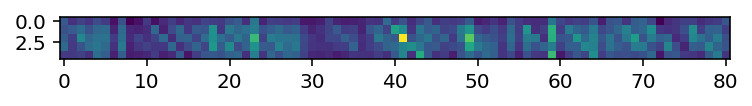

In [9]:
plt.imshow(np.exp(-prBrickwall.T*.04))

In [10]:
prBrickwall.shape[0], len(numAncestor)-genOffset

(81, 81)

The threshold position in the model (55) refers to the index of the free energy up to which the binding is considered productive. Therefore, to get the position in the sequence, we need to add the offset:

In [11]:
seqTh = model["ThDict"]["Pr.Pl"]+genOffset

In [12]:
wtPr_cropped[15:seqTh]+ " | " +wtPr_cropped[seqTh:]

'cctcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtacta | gaattcattaaagaggagaaaggtac'

In [13]:
wtPr_full[15:seqTh]+ " | " +wtPr_full[seqTh:]

'cctcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtacta | gaattcattaaagaggagaaaggtaccatgagtaaaggagaagaactttt'

In [14]:
RBSPos["Pr"]-seqTh

35

Therefore, we determine the closest promotor needs to finish 35 positions before the appropriate ribosomal binding site.

### Matrices and chemical potentials

In [6]:
m = np.vstack(model["matrices"])
chempots = pd.Series(model["chem.pot"])

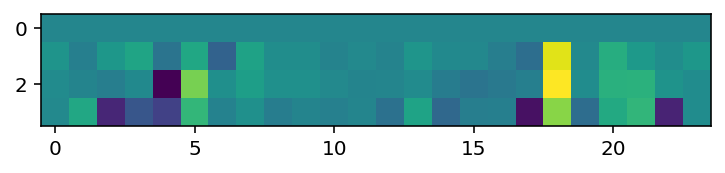

In [7]:
plt.imshow(m.T)

In [8]:
bEoffset = m.min(axis=1)

In [9]:
m-=np.repeat([bEoffset], 4, axis=0).T
chempots -= bEoffset.sum()

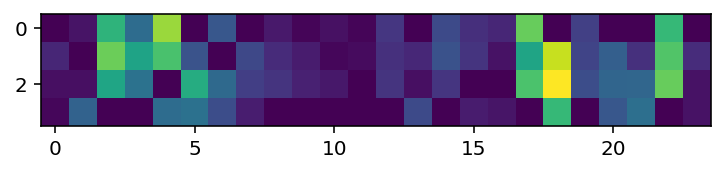

In [10]:
plt.imshow(m.T)

In [11]:
chempots

Pr.Pl    11.128164
36N      10.531435
dtype: float64

In [12]:
lps2eval(model, "mlogL", fit=False, tt="all", numData=numData, DataIDs_=["Pr"])

{'Pr': 9663.548461321703}

In [13]:
tmpmodel = deepcopy(model)
tmpmodel["chem.pot"] = chempots.to_dict()
n1 = model["Layout"][0]
tmpmodel["matrices"] = m[:n1], m[n1:]

In [14]:
lps2eval(tmpmodel, "mlogL", fit=False, tt="all", numData=numData, DataIDs_=["Pr"])

{'Pr': 9663.548461321705}

In [21]:
np.savetxt(saveFolder+"matrix-35.txt", m[:n1], fmt="%.4f", header="A C G T")

In [22]:
np.savetxt(saveFolder+"matrix-10.txt", m[n1:], fmt="%.4f", header="A C G T")

In [25]:
chempots.to_csv(saveFolder+"chem_pots.txt")

In [29]:
np.savetxt(saveFolder+"chem_pots.txt", chempots.values.reshape(1,-1), fmt="%.3f", header=" ".join(chempots.keys()))

### Clearance Rate and spacer penalties

In [36]:
with open(saveFolder+"clearance_rate.txt","w") as f:
    f.write("%.3f"%np.exp(model["logClearanceRate"]))

In [38]:
np.savetxt(saveFolder+"spacer_penalties.txt", model["sp.penalties"].reshape(1,-1), fmt="%.3f", header=" ".join([str(i) for i in range(-2,3)]))